## Quick Finetune in ~40 Lines (NovoMolGen-32M → Perindopril_MPO)

Run the cell below to:
- load the pretrained **NovoMolGen-32M** from the Hub,
- plug in a **Perindopril_MPO** reward,
- and run a short **AugmentedHC** finetune.

This mirrors the repo config, uses BF16 with `Accelerator`, and writes artifacts to `./novomolgen_demo`.


In [ ]:
# NovoMolGen: load → reward → finetune → sample
import os, torch, rootutils
os.environ["TOKENIZERS_PARALLELISM"] = "false"
from pathlib import Path
from accelerate import Accelerator
from transformers import AutoModelForCausalLM, AutoTokenizer

os.chdir(Path(os.getcwd()).parent)
rootutils.setup_root(os.getcwd(), indicator=".project-root", pythonpath=True)

from src.trainer import AugmentedHCConfig, AugmentedHCTrainer
from src.eval import MoleculeEvaluator
from src.utils import _load_cfg, set_seed, plot_reward_with_molecules

# Load from Hub
MODEL_ID = "chandar-lab/NovoMolGen_32M_SMILES_AtomWise"
tokenizer = AutoTokenizer.from_pretrained(MODEL_ID, trust_remote_code=True)
model = AutoModelForCausalLM.from_pretrained(
    MODEL_ID, trust_remote_code=True, torch_dtype=torch.bfloat16, device_map="auto"
)

acc = Accelerator(mixed_precision="bf16")
model = acc.prepare(model)

# Config (same one we use in repo)
cfg = _load_cfg(
    config_name="finetune_PMO_ZINC_1B_atomwise_smiles_llama-32M",
    config_dir="../configs",
    **{
        "finetune.early_stopping": 20,
        "finetune.task_name": "Perindopril_MPO",
    },
)

# Reward (plug-and-play evaluator)
set_seed(cfg.finetune.seed)
task = MoleculeEvaluator(task_names=cfg.finetune.task_name)
def reward_fn(smiles_batch):
    res = task(smiles_batch, filter=True, return_valid_index=True)
    r = torch.zeros(len(smiles_batch), dtype=torch.float32, device=acc.device)
    r[res["valid_index"]] = torch.tensor(res[cfg.finetune.task_name], dtype=torch.float32, device=acc.device)
    return r

# Finetune (AugmentedHC)
ft_cfg = AugmentedHCConfig(output_dir="./novomolgen_demo", **cfg.finetune)
trainer = AugmentedHCTrainer(config=ft_cfg, model=model, reward_fn=reward_fn, tokenizer=tokenizer)

trainer.train(skib_eval=True)

2025-09-02 13:55:07.842 | WARNING  | src.eval.molecule_evaluation:<module>:18 - Failed to import reactivity: xtb C extension unimportable, cannot use C-API
2025-09-02 13:55:08.121 | WARNING  | src.eval.molecule_evaluation:<module>:26 - Failed to import tadf: 'XTBHOME'
Failed to find the pandas get_adjustment() function to patch
Failed to patch pandas - PandasTools will have limited functionality
2025-09-02 13:55:11,307 | INFO     | src.trainer.reinvent_trainer: ***** Running REINVENT trainer *****
2025-09-02 13:55:11,308 | INFO     | src.trainer.reinvent_trainer:   Num Max Iterations = 20
2025-09-02 13:55:11,309 | INFO     | src.trainer.reinvent_trainer:   Num Oracle Calls = 10,000
2025-09-02 13:55:11,310 | INFO     | src.trainer.reinvent_trainer:   Batch Size = 64
2025-09-02 13:55:11,310 | INFO     | src.trainer.reinvent_trainer:   Number of Trainable Parameters = 31,556,096
2025-09-02 13:55:11,311 | INFO     | src.trainer.reinvent_trainer: Prefill experience replay buffer with 100 mo

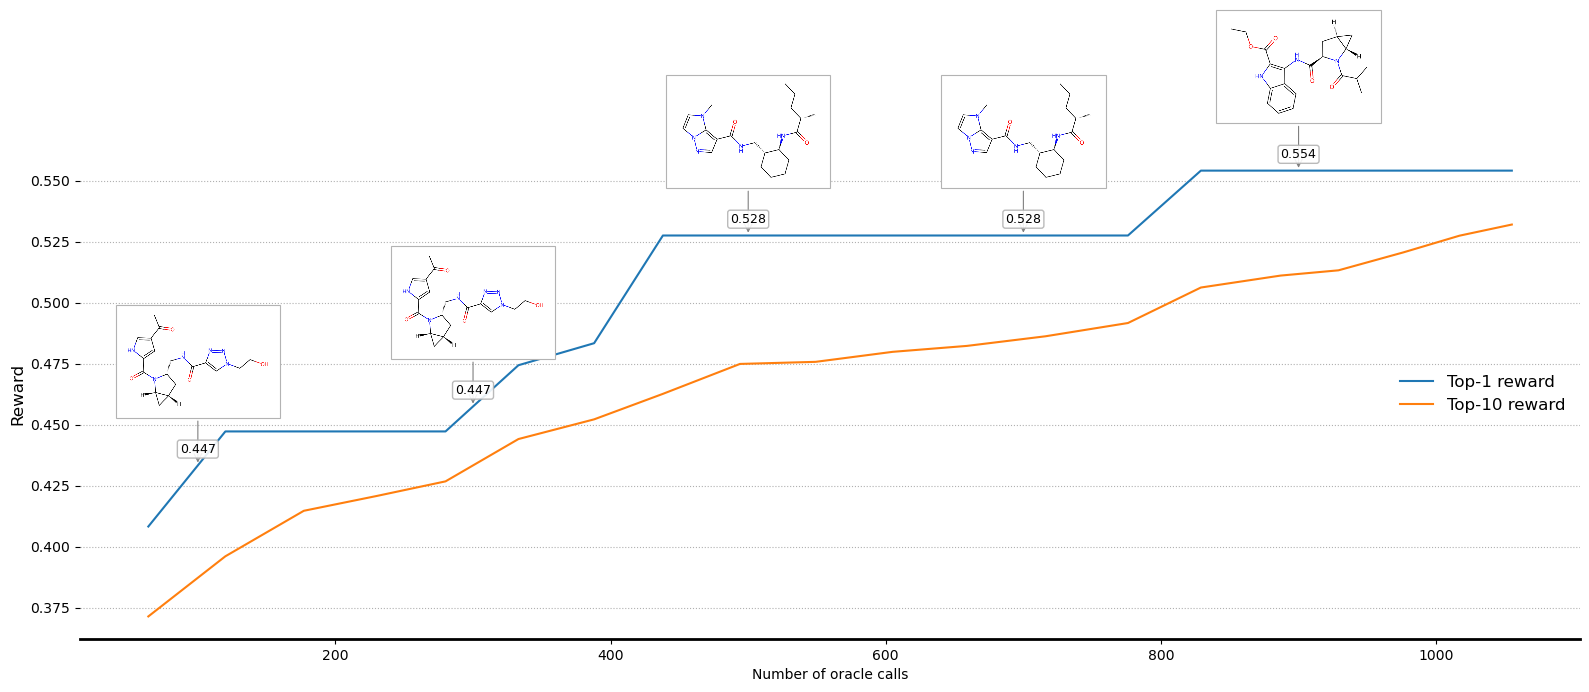

In [2]:
plot_reward_with_molecules(trainer, steps_to_show=(100,300,500,700,900))